<a href="https://colab.research.google.com/github/MAvRK7/Neural-Nets-Learning/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Networks

Micrograd is an autograd (automatic gradient) engine

It implements back-propagation (algo that enables to efficiently evaluate the gradient of some loss function wrt the weights of a NN)

So we can iteratively tune the weights of a neural network to minimize the loss function and improve accuracy of the NN

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# an eg func 3x square - 4x + 5
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.00)

20.0

In [ ]:
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys=f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

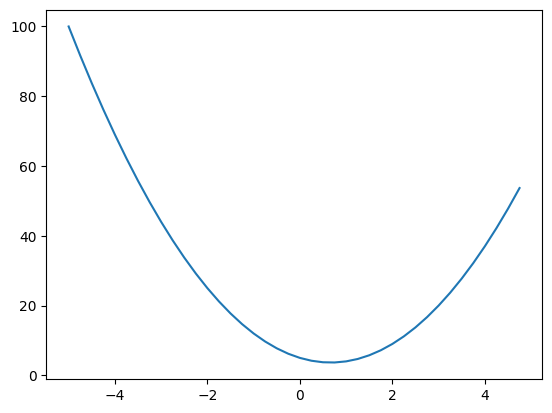

In [ ]:
plt.plot(xs,ys)

Its a parabola

now lets get the slope, lets increase it ever so slighly and - how much it was before, so get exactly how much it responded and then normalise it to get the slope, rise over run

In [ ]:
h=0.00000001
(f(3+h)-f(3))/h

14.00000009255109

so 14 is the slope at 3, whats imp is that its + (rising)

at say -3, the slope will be -, falling

looked this up, at 2/3 its exactly 0

In [ ]:
x=2/3
(f(x+h)-f(x))/h

0.0

In [ ]:
(f(-3+h)-f(-3))/h

-22.00000039920269

#trying a more complex function

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

d1 = a*b + c
print('d1',d1)

c+=h

d2 = a*b + c
print('d2',d2)

slope=(d2-d1)/h
print('slope',slope)

4.0
d1 4.0
d2 4.000000010000001
slope 1.000000082740371


#datastructures for NN

In [ ]:
class Value:
  #this takes in a value
  def __init__(self, data, _children=(), _op=" ", label=" "):
    self.data=data
    self.grad=0.0
    self._prev=set(_children)
    self._op=_op
    self.label=label

  #to print the value in the particular format
  def __repr__(self):
    return f"value(data={self.data})"

  # these Values cant add, so we have to define addition
  def __add__(self, other):
    out = Value(self.data+other.data, (self,other),"+")
    return out

  # to enable multiplication
  def __mul__(self, other):
    out=Value(self.data * other.data, (self,other),"*")
    return out

  #enabling activation func: tanh
  def tanh(self):
    x=self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

a=Value(2.0,label="a")
b=Value(-3.0,label="b")
c=Value(10.0,label="c")
e=a*b; e.label="e"
d=e+c; d.label="d"
f=Value(-2.0, label="f")
L=d*f; L.label="L"
L


value(data=-8.0)

to see the numbers that make up the d value? (how we got here) -> we use ._prev

In [ ]:
d._prev

{value(data=-6.0), value(data=10.0)}

to see what operation was made to get to d we use ._op

In [ ]:
d._op

'+'

visualize with graphviz, to see we added label

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

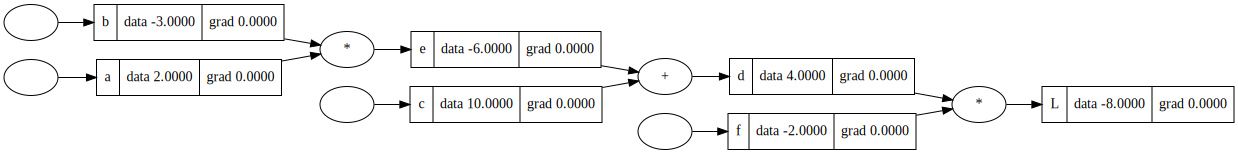

In [ ]:
draw_dot(L)

we see that how is L dependant on d is dL/ dd (differentiation or slope)

we see that dL/dL is 1 or L.grad=1

now we see that dL/dd=f or -2

How?
dl/dd= f(x+h)-f(x) / h AND L=d*f

= (d+h)f-(d)f / h [AS f(x) = d * f so f(x+h) = (d+h) * f]

= df + hf - df/h = hf/h = f

similarly dL/df = d or 4

#Main Q

how is L related to c? (what is dL/dc)

we get that by how is L related to d (or dL/dd)
and how is d related to c (or dd/dc)

we know dL/dd, lets find dd/dc

we know that, d=c+e

dd/dc = (c+h+e) - (c+e) / h

= h/h = 1

so dd/dc = 1.0 and similarly (symmetric) dd/de = 1

Now we can use dd/dc and dL/dd to find dL/dc using the
#chain rule
"if a car is 2x speed of cycle and cycle is 4x speed of a man, the car is (2*4) or 8x faster than a man"

so we multiply; dL/dc = dL/dd * dd/dc

dL/dd is -2 and dd/dc is 1,

dL/dc = -2

dL/de = -2

for finding de/da and de/db

dL/da= dL/de * de/da
     
      (global) (local)
= -2 * -3 = 6

(how?)
e=a*b, and

de/da= (a+h)+b - (a*b) / h

= ab+hb -ab / h = hb/h

=b (which is -3)

so:

de/da= -3 and de/db = 2

hence:

dL/da= 6 and dL/db = -2*2 = -4

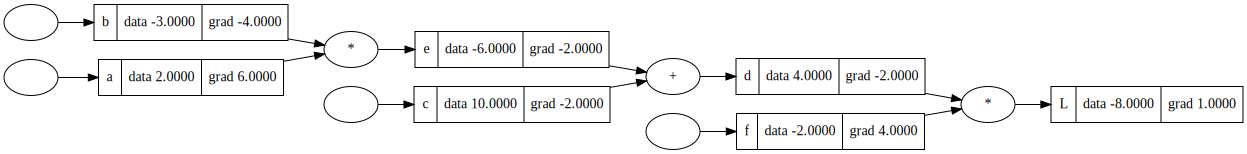

In [ ]:
 L.grad=1
 f.grad=4
 d.grad=-2
 c.grad=-2
 e.grad=-2
 b.grad=-4
 a.grad=6

 draw_dot(L)

so whats the point of finding the slopes (ie) doing back-propagation?

say we want to increase the value of L (ie) L should go from -8 to say -6

then we have to make a go up (along the +ve slope) make it "more" +ve, and make b also go along its negative slope (ie) make it "more" negative


In [ ]:

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e=a*b
d=e+c
L=d*f
print(L.data)

-7.286496


so yeah, L's value became higher

#More complex

A neural net consists of neurons, which are basically summing up the inputs 8 weights-

w1x1+w2x2... + bias

this bias makes it more happy or less (depends)


then it passes through an activation function.

An activation function is basically a "squasher" it makes values small, lets see Tanh

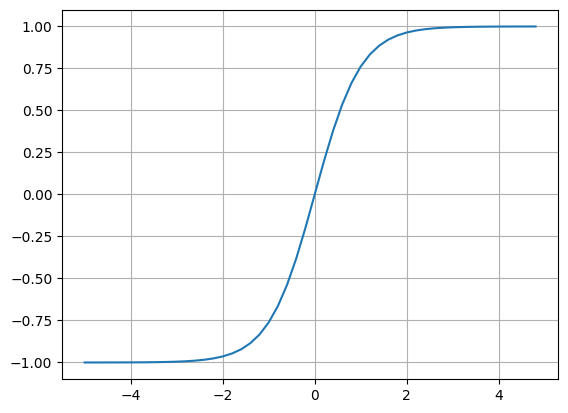

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

what comes out of a neuron is the activation func applied to that product+bias

we need to implement tanh now

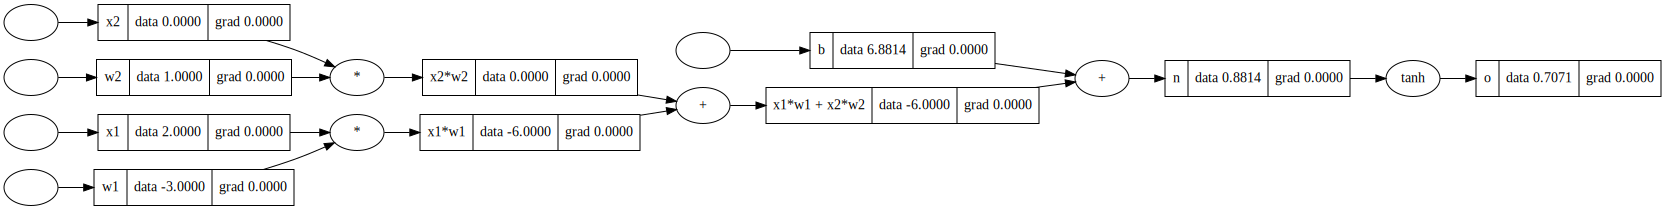

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)

now we need to do back-prop here

starting off do/do = 1

then o=tanh(n), so

do/dn= 1-tanh(n)**2 [from wikipedia]

= 1-(o)**2 [as tanh(n) = o]

= 1-(0.7071)**2

=0.5 is do/dn

now from the prev,
#+ just redistributes the slope,
so b and x1*w1.. is also 0.5

(also dn/db=1+0, since b+x1*w1 = n)

#* gives the local grad of the opposite value
so x2.grad=w2.data * x2w2.grad

= x2.grad= 1*0.5= 0.5


and w2.grad=0*0.5=0



In [ ]:
o.grad=1.0
n.grad=0.5
x1w1x2w2.grad=0.5
b.grad=0.5
x2w2.grad=0.5
x1w1.grad=0.5
x2.grad=w2.data * x2w2.grad
w2.grad=x2.data * x2w2.grad
x1.grad=w1.data * x1w1.grad
w1.grad=x1.data * x1w1.grad


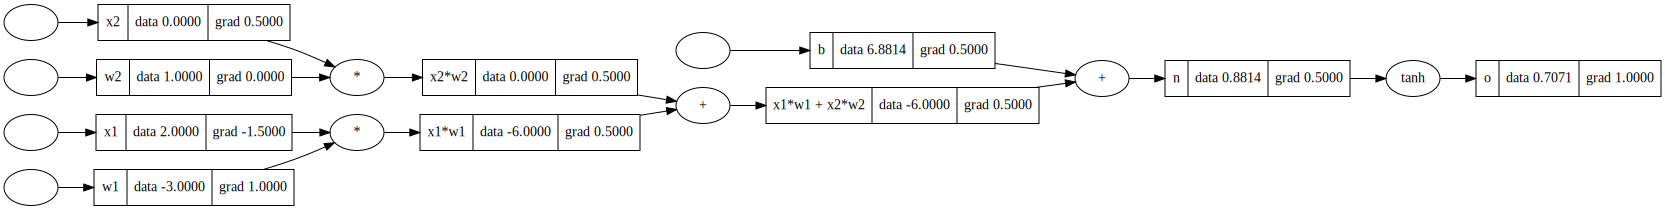

In [ ]:
draw_dot(o)

so here w2 is useless, but if we increase w1 weight, o will increase (since slope is +ve)

Now we are going to stop doing it manually and start coding

In [ ]:
class Value:
  #this takes in a value
  def __init__(self, data, _children=(), _op=" ", label=" "):
    self.data=data
    self.grad=0.0
    #NEW
    self._backward=lambda:None #it does nothing by default because at leaf nodes it should be nothing
    self._prev=set(_children)
    self._op=_op
    self.label=label

  #to print the value in the particular format
  def __repr__(self):
    return f"value(data={self.data})"

  # these Values cant add, so we have to define addition
  def __add__(self, other):
    out = Value(self.data+other.data, (self,other),"+")

    #adding backward to add
    def _backward():
      self.grad=1.0*out.grad
      other.grad=1.0*out.grad
    out._backward=_backward #not _backward() because we need the recipe not the output
    return out

  # to enable multiplication
  def __mul__(self, other):
    out=Value(self.data * other.data, (self,other),"*")
    #adding backward to mul
    def _backward():
      self.grad=other.data*out.grad
      other.grad=self.data*out.grad

    out._backward=_backward
    return out

  #enabling activation func: tanh
  def tanh(self):
    x=self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad=1-(t**2)*out.grad

    out._backward=_backward
    return out

a=Value(2.0,label="a")
b=Value(-3.0,label="b")
c=Value(10.0,label="c")
e=a*b; e.label="e"
d=e+c; d.label="d"
f=Value(-2.0, label="f")
L=d*f; L.label="L"


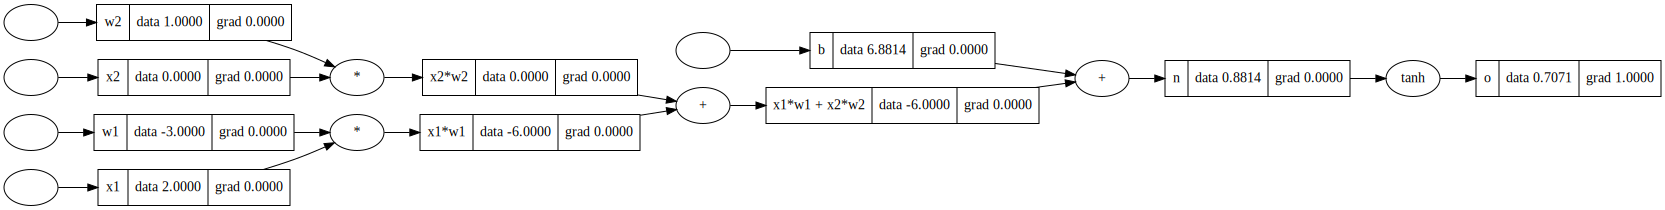

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
#set basecase
o.grad=1.0
draw_dot(o)

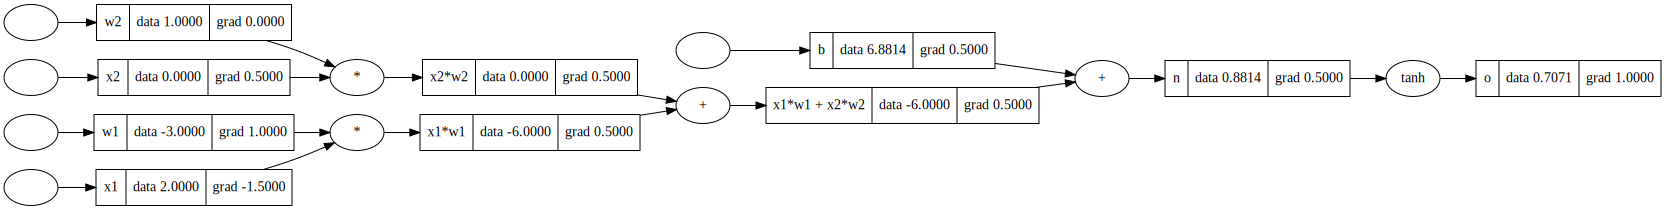

In [ ]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

now instead of manually applying _backward() on all of them, we topologically sort the graph and then reverse it (start from o) and we apply _backward() on all of them

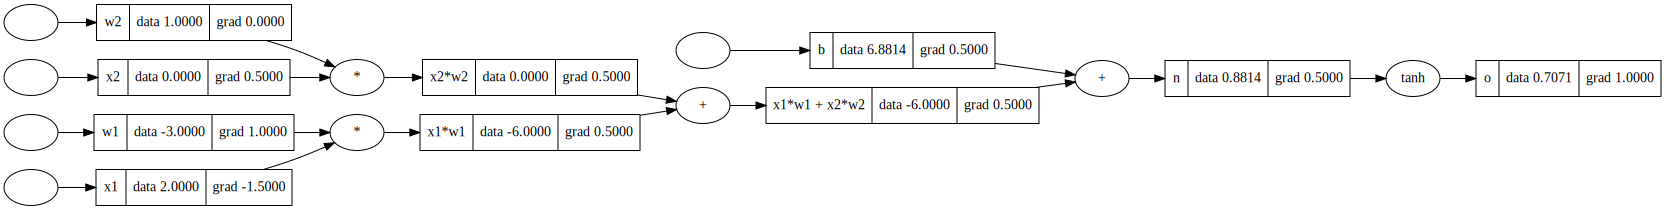

In [ ]:
o.grad=1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for i in reversed(topo):
  i._backward()

draw_dot(o)

we can add this to our main code itself

In [ ]:
#note the self.grad += so when we go backward, the GRADIENT get updated slightly (weights get updated with learning rate)
class Value:
  #this takes in a value
  def __init__(self, data, _children=(), _op=" ", label=" "):
    self.data=data
    self.grad=0.0
    self._backward=lambda:None
    self._prev=set(_children)
    self._op=_op
    self.label=label

  #to print the value in the particular format
  def __repr__(self):
    return f"value(data={self.data})"

  # these Values cant add, so we have to define addition
  def __add__(self, other):
    out = Value(self.data+other.data, (self,other),"+")

    #adding backward to add
    def _backward():
      self.grad+=1.0*out.grad
      other.grad+=1.0*out.grad
    out._backward=_backward
    return out

  # to enable multiplication
  def __mul__(self, other):
    out=Value(self.data * other.data, (self,other),"*")
    #adding backward to mul
    def _backward():
      self.grad+=other.data*out.grad
      other.grad+=self.data*out.grad

    out._backward=_backward
    return out

  #enabling activation func: tanh
  def tanh(self):
    x=self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad+=1-(t**2)*out.grad

    out._backward=_backward
    return out

  #backprop code
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0

    for i in reversed(topo):
      i._backward()


a=Value(2.0,label="a")
b=Value(-3.0,label="b")
c=Value(10.0,label="c")
e=a*b; e.label="e"
d=e+c; d.label="d"
f=Value(-2.0, label="f")
L=d*f; L.label="L"


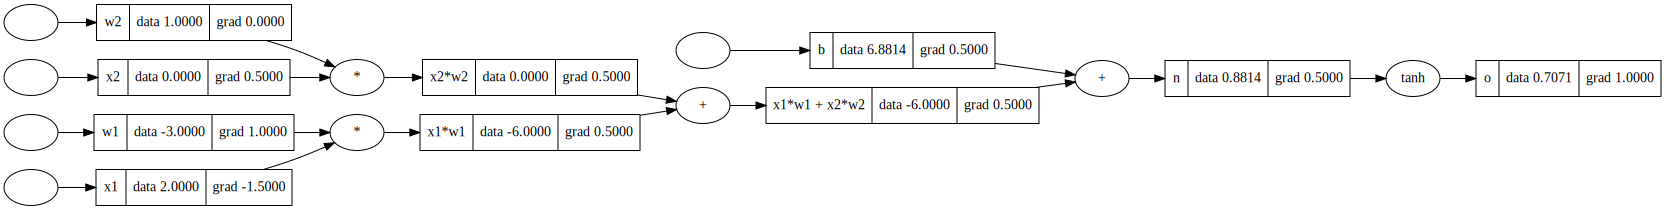

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"

o.backward()
draw_dot(o)

now we want to be able to add numbers directly without making it a Value, and we also want to be able to add exp and div

In [ ]:
class Value:
  #this takes in a value
  def __init__(self, data, _children=(), _op=" ", label=" "):
    self.data=data
    self.grad=0.0
    self._backward=lambda:None
    self._prev=set(_children)
    self._op=_op
    self.label=label

  #to print the value in the particular format
  def __repr__(self):
    return f"value(data={self.data})"

  # these Values cant add, so we have to define addition
  def __add__(self, other):
    other=other if isinstance(other, Value) else Value(other)
    out = Value(self.data+other.data, (self,other),"+")

    #adding backward to add
    def _backward():
      self.grad+=1.0*out.grad
      other.grad+=1.0*out.grad
    out._backward=_backward
    return out

  # to enable multiplication
  def __mul__(self, other):
    other=other if isinstance(other, Value) else Value(other)
    out=Value(self.data * other.data, (self,other),"*")
    #adding backward to mul
    def _backward():
      self.grad+=other.data*out.grad
      other.grad+=self.data*out.grad

    out._backward=_backward
    return out

  def __pow__(self,other):
    assert isinstance(other, (int,float)) #make sure only other values can be ^ to int or float
    out=Value(self.data**other, (self, ), f"**{other}" )
    #derivative of x^n [x is self.data, n is other] with respect to x is n * x^(n-1)
    def _backward():
      self.grad+=(other*(self.data)**(other-1))*out.grad
    out._backward=_backward
    return out


  def __rmul__(self,other): #to enable 2*a (a*2 works but not the other way without this)
    return self * other

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other): #division by using exp (power)
    return self * other**-1

  def __neg__(self): #negation by * with -1
    return -1*self

  def __sub__(self,other): #subtraction by adding -
    return self+(-other)



  #enabling activation func: tanh
  def tanh(self):
    x=self.data
    #e^2x - 1/ e^2x + 1
    #math.exp(2*x) means e^2x
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      #diff of tanh is 1-tan^2 x #there was a crucial bug here i had written self.grad+=1-(t**2)*out.grad
      self.grad += (1 - t**2) * out.grad

    out._backward=_backward
    return out

  #enabling exponentials
  def exp(self):
    x=self.data
    t = (math.exp(x))
    out = Value(t, (self, ), 'exp')
    def _backward():
      self.grad+=out.data*out.grad

    out._backward=_backward
    return out

  #backprop code
  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0

    for i in reversed(topo):
      i._backward()

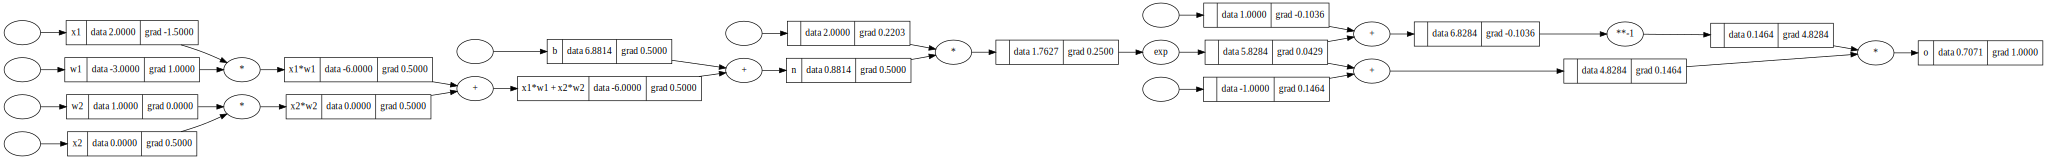

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#-----
e=(2*n).exp() #this is e=exp(2n) = e^2n
o=(e-1)/(e+1)
#-----
o.label = "o"

o.backward()
draw_dot(o)

#PyTorch
In PyTorch everything is not scalar values, it uses Tensors- n dim arrays of scalars


In [ ]:
import torch

this is a tensor, we would work with these values

In [ ]:
torch.tensor([[1,2,3],[4,5,6]]).shape

torch.Size([2, 3])

In [ ]:
#initialising values
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


#we need to explicitely say leaves have gradients here because it assumed they dont by default
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True
n = w1 * x1 + w2 * x2 + b
o=torch.tanh(n)

#o.item or o.data.item both are same, they just give me the scalar without the tensor
print(o.item())
o.backward()


print("---")
print("x2",x2.grad.item())
print("w2",w2.grad.item())
print("x1",x1.grad.item())
print("w1",w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [ ]:
x2.grad.item()

0.5000001283844369

Now we are going to actually implement NN

NN are a specific case of graphs in math

In [ ]:
import random

In [ ]:
class Neuron:
  def __init__(self, nin):
    #nin is number of inputs and the weights are first random values [-1,1] for all the inputs, bias is one random value [-1,1]
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))

  #when we do say n(x) where n is a Neuron, it will call this
  def __call__(self,x):
    #for w1.x1 + b
    #we need to do w1.x1 + w2.x2, so lets zip them (zip combines two iterators)
    act=sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
    out=act.tanh()
    return out

#we passed 2 inputs (say x1=2,x2=3) into a neuron
x=[2.0,3.0]
n=Neuron(2)
n(x)


value(data=-0.9988551677834)

this was for a single neuron, we will now do it for a layer of neurons


In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))


  def __call__(self,x):
    act=sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
    out=act.tanh()
    return out

class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    #feed x to each neuron in this layer, where x is the input to the layer; so 2 goes to all 3 neurons and so does 3
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs


x=[2.0,3.0]
#two imputs for each neuron and there are 3 neurons in this layer
n=Layer(2,3)
n(x)


[value(data=-0.879313706598961),
 value(data=-0.9331739419300618),
 value(data=0.9964850666399518)]

so above, we have 3 neurons each having 2 layers

Now we can have multiple layers and make an MLP

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))

  def __call__(self,x):
    act=sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
    out=act.tanh()
    return out

class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

class MLP:
  #we have muliple outs here (for each of the layers)
  def __init__(self,nin,nouts):
    #size is inputs + nouts of each layer. eg here: [3,4,4,1]
    sz=[nin]+nouts
    #then we make the layers, 3-4; 4-4;4-1
    self.layers=[Layer(sz[i],sz[i+1])for i in range (len(nouts))]

  def __call__(self,x):
    #The result of one Layer becomes the input to the next Layer.
    for layer in self.layers:
      x=layer(x)
    return x


x=[2.0,3.0,-1.0]
#3 inputs, 2 layers of 4 input neurons and 1 final layer
n=MLP(3,[4,4,1])
n(x)


value(data=0.3769525550053308)

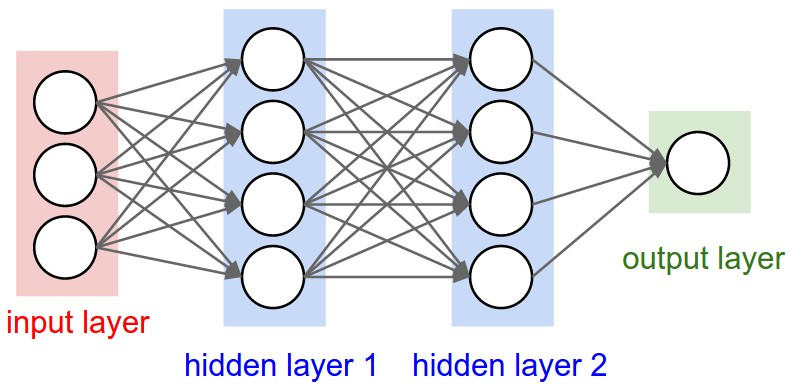

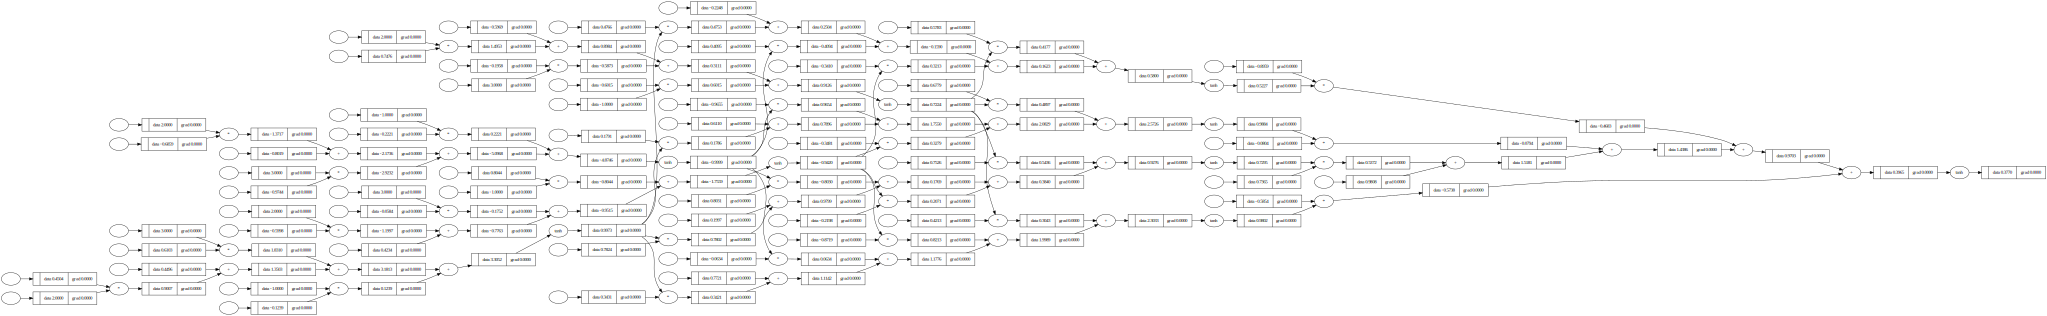

In [ ]:
draw_dot(n(x))

In [ ]:
n(x).backward()

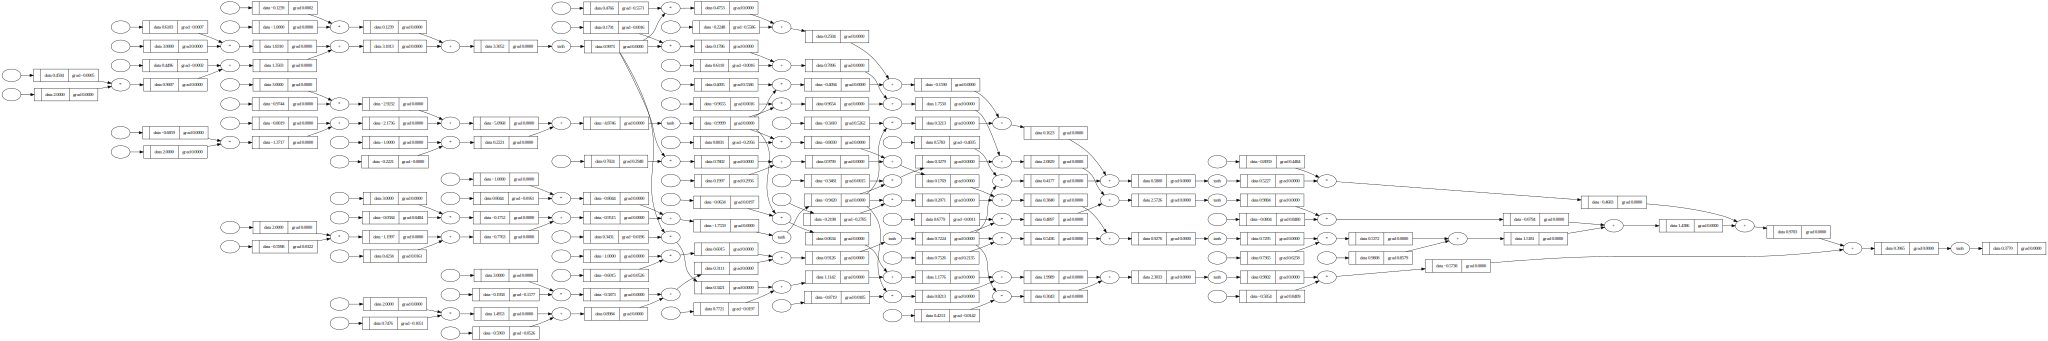

In [ ]:
draw_dot(n(x))

Lets use this MLP now, lets say we had these inputs and we wanted specific outputs (a binary classifier)

In [ ]:
xs=[
    [2.0,3.0,-1.0], #dataset
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys=[1.0,-1.0,-1.0,1.0] #desired outputs
#lets get what this MLP gives for these inputs naturally
ypred=[n(x) for x in xs]
ypred

[value(data=0.3769525550053308),
 value(data=0.39643149318088),
 value(data=0.7747046950567964),
 value(data=0.4271917380949822)]

so the first one should be pushed up, second one -> down, third-> down, forth-> up

we have a single things that measures the entire performance of the NN: called -> Loss

now the loss is high

In [ ]:
[(yout-ygt)**2 for yout,ygt in zip(ypred,ys)]

[value(data=0.3881881187143854),
 value(data=1.9500209151473817),
 value(data=3.149576754656637),
 value(data=0.3281093049066476)]

now the MSE will be the sum of all these numbers

In [ ]:
loss= sum([(yout-ygt)**2 for yout,ygt in zip(ypred,ys)])
loss

value(data=5.815895093425052)

Now lets get the parameters of the neurons, which we want to see to change them

we wont change inputs, we change our weights and bias

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))

  def __call__(self,x):
    act=sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
    out=act.tanh()
    return out

  #for a single neuron, the parameters are weights and bias (not addition, a list of weights and bias)
  def parameters(self):
    return self.w+[self.b] #list + list

class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs=[n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params=[]
    for neuron in self.neurons:
      params+=neuron.parameters() #add each neuron's param into the list
    return params
    #or return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  #we have muliple outs here
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1])for i in range (len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

value(data=-0.8645136026808706)

these are all the weights and biases inside the NN

In [ ]:
n.parameters()

[value(data=-0.3648665958933468),
 value(data=0.03760089641474651),
 value(data=-0.735048896350964),
 value(data=-0.29230922531076264),
 value(data=-0.013660506882998691),
 value(data=0.7229021721678195),
 value(data=-0.1104222633112899),
 value(data=0.8076846609153774),
 value(data=-0.8049496867513175),
 value(data=0.19209841283590556),
 value(data=0.7830238632267776),
 value(data=-0.812380531373222),
 value(data=-0.44111047189114316),
 value(data=0.7530614007801073),
 value(data=-0.44352192553567926),
 value(data=-0.7834736974699319),
 value(data=-0.633524583013096),
 value(data=-0.3615520231575091),
 value(data=-0.5429600721772245),
 value(data=-0.02559425133304316),
 value(data=0.03206286970621064),
 value(data=0.26628381822500535),
 value(data=0.9254206638580953),
 value(data=-0.8798656812921997),
 value(data=-0.6982794884496681),
 value(data=-0.6258956526702193),
 value(data=0.8868608871513619),
 value(data=0.3203837385670769),
 value(data=0.5934819701115752),
 value(data=0.78651

so we have 41 parameters (weights and biases) got that from len()

now we want to change these slighly

we do this again

In [ ]:
xs=[
    [2.0,3.0,-1.0], #dataset
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys=[1.0,-1.0,-1.0,1.0] #desired outputs
#lets get what this MLP gives for these inputs naturally
ypred=[n(x) for x in xs]
ypred

[value(data=-0.8645136026808706),
 value(data=-0.07872832413899893),
 value(data=-0.24965945957445626),
 value(data=-0.743182661974195)]

In [ ]:
loss= sum([(yout-ygt)**2 for yout,ygt in zip(ypred,ys)])
loss

value(data=0.011816059309720392)

In [ ]:
loss.backward()

lets look at a perticular neuron

In [ ]:
n.layers[0].neurons[0].w[0].grad #this is the grad of the first neuron

2.252986131552394

In [ ]:
n.layers[0].neurons[0].w[0].data

-0.3648665958933468

changing parameters slighly acc. gradient info

now all these gradients point towards INCreasing the loss, but we want to decrease the loss- so we add a - sign

In [ ]:
for p in n.parameters():
  p.data+= -0.01* p.grad

automating this:

In [ ]:
for k in range(20):

  #forward pass
  ypred=[n(x) for x in xs]
  loss= sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))

  #backward pass
  for p in n.parameters():
    #dont forget to set the grad to 0 after every iteration
    p.grad=0.0
  loss.backward()

  #update WEIGHTS using learning rate (here its 0.01)
  for p in n.parameters():
    p.data+= -0.01* p.grad

  print (k,loss.data)

0 7.22971937815909
1 6.504620908093108
2 5.7816925156518755
3 5.219087901996683
4 4.83313386485113
5 4.562469540346198
6 4.360246944705107
7 4.1969527864645935
8 4.053886876451131
9 3.919804838996372
10 3.7888505128378975
11 3.658787467862224
12 3.5293494557500145
13 3.400918524587955
14 3.273729743709236
15 3.147544505154725
16 3.021587072427546
17 2.8945871893947794
18 2.7648769180612627
19 2.6305658880987566


results

In [ ]:
ypred

[value(data=0.5021410710419104),
 value(data=-0.2768535430515884),
 value(data=-0.11628160328132167),
 value(data=-0.038654597091539275)]

In [ ]:
xs=[
    [2.0,3.0,-1.0], #dataset
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]

ys=[1.0,-1.0,-1.0,1.0] #desired outputs

In [ ]:
for k in range(30):

  #forward pass
  ypred=[n(x) for x in xs]
  loss= sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))

  #backward pass
  for p in n.parameters():
    #dont forget to set the grad to 0 after every iteration
    p.grad=0.0
  loss.backward()

  #update WEIGHTS using learning rate (here its 0.01)
  for p in n.parameters():
    p.data+= -0.1* p.grad

  print (k,loss.data)

0 0.029810774719335412
1 0.0283816365049748
2 0.027078400204584532
3 0.025885313479135398
4 0.024789133136734205
5 0.023778646122187393
6 0.022844296004730955
7 0.021977888849622994
8 0.02117235948813658
9 0.020421584213633978
10 0.019720229503909163
11 0.01906362894739339
12 0.01844768243170399
13 0.01786877304031479
14 0.017323698136607585
15 0.01680961189167115
16 0.01632397710168105
17 0.015864524591514106
18 0.015429218848719575
19 0.015016228801740063
20 0.014623902867174306
21 0.014250747556830073
22 0.013895409066717532
23 0.013556657374788488
24 0.013233372458050247
25 0.012924532307173898
26 0.01262920247133819
27 0.012346526910471816
28 0.012075719968341812
29 0.011816059309720392


In [ ]:
ypred

[value(data=0.9517870742493024),
 value(data=-0.9568624110572327),
 value(data=-0.9359579212085876),
 value(data=0.9405918047357313)]

What we did here was
#Gradient Descent
the values we're getting as output will be near to 1,-1,-1,1 if we run the fwd, bckwd and updating code